# **BASELINE - UNET**

# Architecture

Type info here

# Import Dependencies

In [34]:
# File Support
try: 
    import pydicom as dcm
except:
    # Use try except for Google Colab
    !pip install pydicom
from pydicom.data import get_testdata_files
import xml
import xml.etree.ElementTree as ET 

# Base
import numpy as np
import pandas as pd
import json
import random
import gc
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.path import Path
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import seaborn as sns
from PIL import Image

# SK-learn
import sklearn
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV

# Files
import os
from os.path import join, split
from glob import glob

# Torch
import torch
from torch import nn
from torch.nn import Conv2d, MaxPool2d, ReLU, ConvTranspose2d
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
import torchvision
from torchvision.transforms import CenterCrop
import torch.nn.functional as F
from torch.optim import AdamW
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.checkpoint import checkpoint
from torch.autograd import Variable

import tempfile
import torch.multiprocessing as mp
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed.fsdp import CPUOffload, wrap
import bitsandbytes as bnb

In [35]:
torch.__version__

'2.2.2+cu121'

In [36]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"

In [37]:
torch.cuda.is_available()

True

# Config

In [38]:
len(os.listdir("Numpy Dataset\\all\images"))

7547

In [39]:
class CFG:
    random_seed = 42
    gated = True
    path = "Coronary CT Data\Gated_release_final" if gated else "Coronary CT Data/deidentified_nongated"
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    train_new = True
    model_num = len(os.listdir("Models")) if train_new else len(os.listdir("Models"))-1

    batch_size = 8
    nEpochs = 100
    lr = 0.1


In [40]:
import warnings
warnings.filterwarnings("ignore")

In [41]:
torch.cuda.empty_cache()
gc.collect()

3207

In [42]:
def setup(rank, world_size):
    os.environ['MASTER_ADDR'] = 'localhost'
    os.environ['MASTER_PORT'] = '12355'

    # initialize the process group
    dist.init_process_group("gloo", rank=rank, world_size=world_size)

def cleanup():
    dist.destroy_process_group()

## Reproducibility

In [43]:
def set_seed(seed=CFG.random_seed):
    print(f"Seed: {seed}")
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

set_seed()

Seed: 42


# Load Data

In [44]:
def parseXML(xmlfile): 
    # create element tree object 
    tree = ET.parse(xmlfile) 

    all_images = []

    images = tree.find("dict").find("array")
    images = images.findall("dict")

    # Images
    for image in images:
        image_data = {}
        arr = [i.text for i in image if i.tag not in ["array", "dict"]]
        
        for i in range(len(arr)//2):
            image_data[arr[2*i]] = arr[2*i+1]

        image_data['ROIs'] = []

        # ROI
        all_roi = image.find("array").findall('dict')
        for roi in all_roi:
            roi_data = {}
            arr = [i.text for i in roi if i.tag not in ["array", "dict"]]
        
            for i in range(len(arr)//2):
                roi_data[arr[2*i]] = arr[2*i+1]

            all_points = roi.findall('array')
            roi_data['point_mm'] = [i.text for i in all_points[0].findall("string")]
            roi_data['point_px'] = [i.text for i in all_points[1].findall("string")]
            
            image_data['ROIs'].append(roi_data)
        all_images.append(image_data)

    return all_images

In [45]:
def create_segments(image_array, points):
    polygon = Polygon(points, closed=True, edgecolor='r', facecolor='r')
    polygon_indices = np.array(points)
    polygon_indices[:, 0] = np.clip(polygon_indices[:, 0], 0, 511)
    polygon_indices[:, 1] = np.clip(polygon_indices[:, 1], 0, 511)
    image_array[polygon_indices[:, 1], polygon_indices[:, 0]] = 1
    polygon_path = Path(polygon_indices)
    x, y = np.meshgrid(np.arange(512), np.arange(512))
    points = np.column_stack((x.flatten(), y.flatten()))
    mask = polygon_path.contains_points(points).reshape(512, 512)
    image_array[mask] = 1

    return image_array

In [46]:
class CTDataset(Dataset):
    def __init__(self, dir):
        super().__init__()
        self.dir = dir
        self.images_path = join(dir, "images")
        self.labels_path = join(dir, "labels")
        self.images = os.listdir(self.images_path)
        self.labels = os.listdir(self.labels_path)

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx): # Return tuple (x, y)
        try:
            img = np.load(join(self.images_path, self.images[idx]), allow_pickle=True)
            img = img.reshape(1, 512, 512) # Hard coded since all images are 512, 512

            label = np.load(join(self.labels_path, self.labels[idx]), allow_pickle=True)
            label = label.reshape(1, 512, 512)
        except:
            img, label = np.zeros((1,512,512), np.float32),np.zeros((1,512,512), np.float32)
        return  img,label

In [47]:
train = CTDataset("Numpy Dataset\\train")
valid = CTDataset("Numpy Dataset\\valid")
test = CTDataset("Numpy Dataset\\test")

In [48]:
trainDL = DataLoader(train, batch_size=CFG.batch_size,shuffle=True, pin_memory=True)
validDL = DataLoader(valid, batch_size=CFG.batch_size)
testDL = DataLoader(test, batch_size=1)

In [49]:
print(f"Train: {len(train)}")
print(f"Valid: {len(valid)}")
print(f"Test: {len(test)}")

Train: 5331
Valid: 1598
Test: 616


# Model

In [50]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()

        self.conv1 = Conv2d(in_ch, out_ch, 3, padding=1)
        self.relu  = ReLU()
        self.conv2 = Conv2d(out_ch, out_ch, 3, padding=1)
        self.conv3 = Conv2d(out_ch, out_ch, 5, padding=2)

        # init random weights
        nn.init.xavier_normal_(self.conv1.weight)
        nn.init.zeros_(self.conv1.bias)

        nn.init.xavier_normal_(self.conv2.weight)
        nn.init.zeros_(self.conv2.bias)

        nn.init.xavier_normal_(self.conv3.weight)
        nn.init.zeros_(self.conv3.bias)
    
    def forward(self, x):
        return self.relu(self.conv3(self.relu(self.conv2(self.relu(self.conv1(x))))))

In [51]:
class AutoEncoder(nn.Module):
    def __init__(self, channels = (1,32,64,128,256,512,1024)):
        super().__init__()
        self.channels = channels
        self.pool = MaxPool2d((2,2))

        self.encoder = nn.ModuleList([
            Block(channels[i], channels[i+1]) for i in range(len(channels)-1) # 1, 32, ..., 1024
        ])

    def forward(self, x):
        skip_out = []
        for block in self.encoder: # Goes through all blocks, passes through block and saves skip output
            x = block(x)
            skip_out.append(x)
            x = self.pool(x) # Reduces dim
        return skip_out

In [52]:
class AutoDecoder(nn.Module):
    def __init__(self, channels = (1,32,64,128,256,512,1024)):
        super().__init__()
        self.channels = channels[:0:-1] # Reverse of Encoder (Excluding First Unneeded in Output)
        self.pool = MaxPool2d((2,2))
        self.upconv = nn.ModuleList([
            ConvTranspose2d(self.channels[i], self.channels[i+1], 2, 2) for i in range(len(self.channels)-1)
        ])

        self.decoder = nn.ModuleList([
            Block(self.channels[i], self.channels[i+1]) for i in range(len(self.channels)-1)
        ])

    def center_crop(self, x, enc_out): # Crop encoder output
        _, _, h, w = x.shape
        enc_out = CenterCrop([h,w])(enc_out)
        return enc_out
    
    def forward(self, x, enc_out:list):
        for i in range(len(self.channels)-1):
            x = self.upconv[i](x)
            enc_ftrs = self.center_crop(x, enc_out[i]) # Crop Skip
            x = torch.cat([x, enc_ftrs], dim=1) # Concatenate Decoder and Skip
            x = self.decoder[i](x)

            # Min Max Scaling [0,1]
            x = (x-x.min())/(x.max()-x.min())
        return x


In [53]:
class UNET(nn.Module):
    def __init__(self, channels = (1,32,64,128,256,512, 1024, 2048)):
        super().__init__()

        # Encoder Path
        self.enc_path = AutoEncoder(channels)

        # Decoder Path
        self.dec_path = AutoDecoder(channels)

        self.out = Conv2d(channels[1], 1, 1)

        # init random weights
        nn.init.xavier_normal_(self.out.weight)
        nn.init.zeros_(self.out.bias)

    
    def forward(self, x):
        skips = self.enc_path(x)
        x = self.dec_path(skips[::-1][0], skips[::-1][1:]) 
        # Reverse of enc_out = upward path of decoder 
        #  [0] -> 1024 output
        # [1:] -> All other skip outputs
        x = self.out(x)
        # x = F.interpolate(x, (512,512))
        x = F.sigmoid(x)

        return x

In [54]:
if not CFG.train_new:
    try:
        model = torch.load(f"Models/{CFG.model_name}/{CFG.model_name}.pt")
    except FileNotFoundError:
        print("Model not found in models folder")

# Train

## Dice Loss

Sørensen–Dice coefficient:
[Wikipedia](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient)
</br>
$${\displaystyle DSC={\frac {2|X\cap Y|}{|X|+|Y|}}}

In [55]:
class diceCoef(nn.Module):
    def init(self):
        super(diceCoef, self).init()

    def forward(self, inputs, targets, smooth=1):        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

In [56]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE

In [57]:
class IoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoULoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions 
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth)
                
        return 1 - IoU

In [58]:
class TverskyLoss(nn.Module):
    def __init__(self, weight=None, size_average=True, ALPHA = 0.5, BETA = 0.5):
        super(TverskyLoss, self).__init__()
        self.alpha = ALPHA
        self.beta = BETA

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #True Positives, False Positives & False Negatives
        TP = (inputs * targets).sum()    
        FP = ((1-targets) * inputs).sum()
        FN = (targets * (1-inputs)).sum()
       
        Tversky = (TP + smooth) / (TP + self.alpha*FP + self.beta*FN + smooth)  
        
        return 1 - Tversky

In [59]:
criterion_dice = DiceBCELoss()

In [60]:
criterion_iou = IoULoss()

In [61]:
criterion_bce = torch.nn.BCEWithLogitsLoss()

In [62]:
criterion_tversk = TverskyLoss()

* Pixel Binary
* IOU
* BCE Dice

## Training Loop

In [63]:
trainDL = DataLoader(train, batch_size=16, shuffle=True)
validDL = DataLoader(valid, batch_size=16, shuffle=False)

In [64]:
def train_epoch(model,  criterion, optim, scheduler):      
    train_loss = 0
    bce_loss = 0
    iou_loss = 0
    dice_loss = 0
    for x,y in tqdm(trainDL):
        x, y = x.to(CFG.device), y.to(CFG.device)
        optim.zero_grad()
        with torch.cuda.amp.autocast(dtype=torch.float16):
            pred = checkpoint(model, x).detach()
            loss = criterion(pred, y)
            loss = Variable(loss, requires_grad=True)
            
        loss.backward()
        optim.step()
        train_loss += loss
        del x,y,pred,loss
    
    
    # eval
    with torch.no_grad():
        for x,y in validDL:
            x, y = x.to(CFG.device), y.to(CFG.device)
            pred = model(x).detach()
            loss_bce = criterion_bce(pred, y)
            loss_dice = criterion_dice(pred,y)
            loss_iou = criterion_iou(pred, y)
            bce_loss += loss_bce
            iou_loss += loss_iou
            dice_loss += loss_dice
    
    scheduler.step(bce_loss)
        
    avg_train_loss = train_loss/len(trainDL)
    avg_bce_loss = bce_loss/len(validDL)
    avg_iou_loss = iou_loss/len(validDL)
    avg_dice_loss = dice_loss/len(validDL)

    
    print(f"Train Loss: {avg_train_loss}")
    print(f"Validation BCE Loss: {avg_bce_loss}")
    print(f"Validation Dice Loss: {avg_dice_loss}")
    print(f"Validation IOU Loss: {avg_iou_loss}")
    return avg_train_loss, avg_dice_loss

In [65]:
def run_model(criterion, model = None, init_lr = 0.1, name = "model", nEpochs = CFG.nEpochs):
    if not model:
        model = UNET().to(CFG.device)
    model.train()

    optim = AdamW(model.parameters(), lr=init_lr)
    scheduler = lr_scheduler.ReduceLROnPlateau(optim, factor=0.5, min_lr=0.0001, verbose=True)


    train_hist = []
    val_hist = []

    for e in range(nEpochs):
        print(f"\n\n[INFO] Epoch {e+1}/{nEpochs}")
        train_loss, val_loss = train_epoch(model, criterion, optim, scheduler)
        train_hist.append(float(train_loss.detach().cpu()))
        val_hist.append(float(val_loss.detach().cpu()))

    if not os.path.exists(f"Models/{name}"):
        os.mkdir(f"Models/{name}")
    torch.save(model.state_dict(), f"Models/{name}/model.pt")

    history = pd.DataFrame({"train":train_hist, 
                         'validation':val_hist}, index = range(1,len(train_hist)+1))
    
    history.to_csv(f"Models/{name}/logs.csv")

In [67]:
for i in range(200):
    a = random.randint(1,100)
    b= random.randint(1,100)

    criterion = TverskyLoss(a/100, b/100)
    run_model(criterion=criterion, name=f"UNET4-{i}", nEpochs=2)
    with open(f"Models/UNET4-{i}/info.txt", "w") as file:
        file.write(f'A={a}, B={b}')
        file.close()



[INFO] Epoch 1/2


100%|██████████| 334/334 [01:56<00:00,  2.88it/s]


Train Loss: 0.999648928642273
Validation BCE Loss: 0.966810405254364
Validation Dice Loss: 1.9667773246765137
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 2/2


100%|██████████| 334/334 [01:56<00:00,  2.87it/s]


Train Loss: 0.9996482729911804
Validation BCE Loss: 0.966810405254364
Validation Dice Loss: 1.9667773246765137
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 1/2


100%|██████████| 334/334 [01:56<00:00,  2.86it/s]


Train Loss: 0.9996470808982849
Validation BCE Loss: 0.9872558116912842
Validation Dice Loss: 1.9872229099273682
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 2/2


100%|██████████| 334/334 [01:56<00:00,  2.87it/s]


Train Loss: 0.9996477961540222
Validation BCE Loss: 0.9872558116912842
Validation Dice Loss: 1.9872229099273682
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 1/2


100%|██████████| 334/334 [01:56<00:00,  2.87it/s]


Train Loss: 0.9996477365493774
Validation BCE Loss: 0.9362158179283142
Validation Dice Loss: 1.9361828565597534
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 2/2


100%|██████████| 334/334 [01:53<00:00,  2.95it/s]


Train Loss: 0.9996461868286133
Validation BCE Loss: 0.9362158179283142
Validation Dice Loss: 1.9361828565597534
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 1/2


100%|██████████| 334/334 [01:53<00:00,  2.96it/s]


Train Loss: 0.9996462464332581
Validation BCE Loss: 0.9930200576782227
Validation Dice Loss: 1.9929866790771484
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 2/2


100%|██████████| 334/334 [01:53<00:00,  2.96it/s]


Train Loss: 0.9996464252471924
Validation BCE Loss: 0.9930200576782227
Validation Dice Loss: 1.9929866790771484
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 1/2


100%|██████████| 334/334 [01:53<00:00,  2.95it/s]


Train Loss: 0.9996461868286133
Validation BCE Loss: 0.9740671515464783
Validation Dice Loss: 1.9740339517593384
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 2/2


100%|██████████| 334/334 [01:53<00:00,  2.95it/s]


Train Loss: 0.9996469020843506
Validation BCE Loss: 0.9740671515464783
Validation Dice Loss: 1.9740339517593384
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 1/2


100%|██████████| 334/334 [01:53<00:00,  2.95it/s]


Train Loss: 0.999647319316864
Validation BCE Loss: 0.9724971652030945
Validation Dice Loss: 1.9724640846252441
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 2/2


100%|██████████| 334/334 [01:53<00:00,  2.95it/s]


Train Loss: 0.9996477961540222
Validation BCE Loss: 0.9724971652030945
Validation Dice Loss: 1.9724640846252441
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 1/2


100%|██████████| 334/334 [01:53<00:00,  2.95it/s]


Train Loss: 0.9996464252471924
Validation BCE Loss: 1.0039700269699097
Validation Dice Loss: 2.003937005996704
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 2/2


100%|██████████| 334/334 [01:53<00:00,  2.95it/s]


Train Loss: 0.9996472597122192
Validation BCE Loss: 1.0039700269699097
Validation Dice Loss: 2.003937005996704
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 1/2


100%|██████████| 334/334 [01:53<00:00,  2.95it/s]


Train Loss: 0.9996479749679565
Validation BCE Loss: 0.9872723817825317
Validation Dice Loss: 1.987238883972168
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 2/2


100%|██████████| 334/334 [01:53<00:00,  2.95it/s]


Train Loss: 0.999647319316864
Validation BCE Loss: 0.9872723817825317
Validation Dice Loss: 1.987238883972168
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 1/2


100%|██████████| 334/334 [01:53<00:00,  2.95it/s]


Train Loss: 0.9996486902236938
Validation BCE Loss: 0.9424700140953064
Validation Dice Loss: 1.9424370527267456
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 2/2


100%|██████████| 334/334 [01:53<00:00,  2.95it/s]


Train Loss: 0.999648928642273
Validation BCE Loss: 0.9424700140953064
Validation Dice Loss: 1.9424370527267456
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 1/2


100%|██████████| 334/334 [01:53<00:00,  2.95it/s]


Train Loss: 0.999648928642273
Validation BCE Loss: 0.9676463603973389
Validation Dice Loss: 1.9676129817962646
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 2/2


100%|██████████| 334/334 [01:53<00:00,  2.95it/s]


Train Loss: 0.9996494650840759
Validation BCE Loss: 0.9676463603973389
Validation Dice Loss: 1.9676129817962646
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 1/2


100%|██████████| 334/334 [01:53<00:00,  2.95it/s]


Train Loss: 0.9996465444564819
Validation BCE Loss: 0.9635887742042542
Validation Dice Loss: 1.9635554552078247
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 2/2


100%|██████████| 334/334 [01:53<00:00,  2.95it/s]


Train Loss: 0.9996474385261536
Validation BCE Loss: 0.9635887742042542
Validation Dice Loss: 1.9635554552078247
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 1/2


100%|██████████| 334/334 [01:53<00:00,  2.95it/s]


Train Loss: 0.9996461868286133
Validation BCE Loss: 1.0187216997146606
Validation Dice Loss: 2.0186879634857178
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 2/2


100%|██████████| 334/334 [01:53<00:00,  2.95it/s]


Train Loss: 0.9996458888053894
Validation BCE Loss: 1.0187216997146606
Validation Dice Loss: 2.0186879634857178
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 1/2


100%|██████████| 334/334 [01:53<00:00,  2.95it/s]


Train Loss: 0.9996470808982849
Validation BCE Loss: 0.9890096783638
Validation Dice Loss: 1.9889758825302124
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 2/2


100%|██████████| 334/334 [01:53<00:00,  2.95it/s]


Train Loss: 0.9996474385261536
Validation BCE Loss: 0.9890096783638
Validation Dice Loss: 1.9889758825302124
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 1/2


100%|██████████| 334/334 [01:53<00:00,  2.96it/s]


Train Loss: 0.9996503591537476
Validation BCE Loss: 0.9122638702392578
Validation Dice Loss: 1.912231206893921
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 2/2


100%|██████████| 334/334 [01:53<00:00,  2.95it/s]


Train Loss: 0.999649167060852
Validation BCE Loss: 0.9122638702392578
Validation Dice Loss: 1.912231206893921
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 1/2


100%|██████████| 334/334 [01:52<00:00,  2.96it/s]


Train Loss: 0.9996474385261536
Validation BCE Loss: 0.9589358568191528
Validation Dice Loss: 1.9589027166366577
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 2/2


100%|██████████| 334/334 [01:53<00:00,  2.95it/s]


Train Loss: 0.9996486902236938
Validation BCE Loss: 0.9589358568191528
Validation Dice Loss: 1.9589027166366577
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 1/2


100%|██████████| 334/334 [01:53<00:00,  2.95it/s]


Train Loss: 0.9996485114097595
Validation BCE Loss: 0.9794979691505432
Validation Dice Loss: 1.9794646501541138
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 2/2


100%|██████████| 334/334 [01:53<00:00,  2.95it/s]


Train Loss: 0.9996477961540222
Validation BCE Loss: 0.9794979691505432
Validation Dice Loss: 1.9794646501541138
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 1/2


100%|██████████| 334/334 [01:52<00:00,  2.96it/s]


Train Loss: 0.9996463656425476
Validation BCE Loss: 1.0018666982650757
Validation Dice Loss: 2.001833438873291
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 2/2


100%|██████████| 334/334 [01:53<00:00,  2.95it/s]


Train Loss: 0.9996467232704163
Validation BCE Loss: 1.0018666982650757
Validation Dice Loss: 2.001833438873291
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 1/2


100%|██████████| 334/334 [01:53<00:00,  2.96it/s]


Train Loss: 0.9996474385261536
Validation BCE Loss: 0.9536645412445068
Validation Dice Loss: 1.9536306858062744
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 2/2


100%|██████████| 334/334 [01:53<00:00,  2.95it/s]


Train Loss: 0.9996502995491028
Validation BCE Loss: 0.9536645412445068
Validation Dice Loss: 1.9536306858062744
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 1/2


100%|██████████| 334/334 [01:52<00:00,  2.96it/s]


Train Loss: 0.9996486902236938
Validation BCE Loss: 0.9722787737846375
Validation Dice Loss: 1.9722450971603394
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 2/2


100%|██████████| 334/334 [01:53<00:00,  2.95it/s]


Train Loss: 0.9996486902236938
Validation BCE Loss: 0.9722787737846375
Validation Dice Loss: 1.9722450971603394
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 1/2


100%|██████████| 334/334 [01:53<00:00,  2.95it/s]


Train Loss: 0.9996476173400879
Validation BCE Loss: 0.983851432800293
Validation Dice Loss: 1.9838184118270874
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 2/2


100%|██████████| 334/334 [01:53<00:00,  2.95it/s]


Train Loss: 0.9996474385261536
Validation BCE Loss: 0.983851432800293
Validation Dice Loss: 1.9838184118270874
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 1/2


100%|██████████| 334/334 [01:53<00:00,  2.95it/s]


Train Loss: 0.9996476173400879
Validation BCE Loss: 0.9516705870628357
Validation Dice Loss: 1.9516379833221436
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 2/2


100%|██████████| 334/334 [01:53<00:00,  2.95it/s]


Train Loss: 0.9996481537818909
Validation BCE Loss: 0.9516705870628357
Validation Dice Loss: 1.9516379833221436
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 1/2


100%|██████████| 334/334 [01:53<00:00,  2.94it/s]


Train Loss: 0.9996457695960999
Validation BCE Loss: 0.9449816942214966
Validation Dice Loss: 1.9449491500854492
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 2/2


100%|██████████| 334/334 [01:53<00:00,  2.95it/s]


Train Loss: 0.9996491074562073
Validation BCE Loss: 0.9449816942214966
Validation Dice Loss: 1.9449491500854492
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 1/2


100%|██████████| 334/334 [01:53<00:00,  2.95it/s]


Train Loss: 0.9996446371078491
Validation BCE Loss: 0.9776127934455872
Validation Dice Loss: 1.9775789976119995
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 2/2


100%|██████████| 334/334 [01:53<00:00,  2.95it/s]


Train Loss: 0.9996479153633118
Validation BCE Loss: 0.9776127934455872
Validation Dice Loss: 1.9775789976119995
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 1/2


100%|██████████| 334/334 [01:53<00:00,  2.95it/s]


Train Loss: 0.9996479153633118
Validation BCE Loss: 0.972321629524231
Validation Dice Loss: 1.9722886085510254
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 2/2


100%|██████████| 334/334 [01:53<00:00,  2.95it/s]


Train Loss: 0.9996488094329834
Validation BCE Loss: 0.972321629524231
Validation Dice Loss: 1.9722886085510254
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 1/2


100%|██████████| 334/334 [01:53<00:00,  2.96it/s]


Train Loss: 0.9996492862701416
Validation BCE Loss: 0.94041907787323
Validation Dice Loss: 1.9403856992721558
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 2/2


100%|██████████| 334/334 [01:53<00:00,  2.95it/s]


Train Loss: 0.9996486902236938
Validation BCE Loss: 0.94041907787323
Validation Dice Loss: 1.9403856992721558
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 1/2


100%|██████████| 334/334 [01:53<00:00,  2.95it/s]


Train Loss: 0.9996477961540222
Validation BCE Loss: 0.9849181771278381
Validation Dice Loss: 1.984885573387146
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 2/2


100%|██████████| 334/334 [01:53<00:00,  2.95it/s]


Train Loss: 0.9996463656425476
Validation BCE Loss: 0.9849181771278381
Validation Dice Loss: 1.984885573387146
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 1/2


100%|██████████| 334/334 [01:53<00:00,  2.95it/s]


Train Loss: 0.9996471405029297
Validation BCE Loss: 0.9793214797973633
Validation Dice Loss: 1.9792876243591309
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 2/2


100%|██████████| 334/334 [01:53<00:00,  2.95it/s]


Train Loss: 0.999646782875061
Validation BCE Loss: 0.9793214797973633
Validation Dice Loss: 1.9792876243591309
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 1/2


100%|██████████| 334/334 [01:53<00:00,  2.95it/s]


Train Loss: 0.9996477961540222
Validation BCE Loss: 0.9762652516365051
Validation Dice Loss: 1.9762325286865234
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 2/2


100%|██████████| 334/334 [01:53<00:00,  2.95it/s]


Train Loss: 0.9996476173400879
Validation BCE Loss: 0.9762652516365051
Validation Dice Loss: 1.9762325286865234
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 1/2


100%|██████████| 334/334 [01:53<00:00,  2.95it/s]


Train Loss: 0.9996458888053894
Validation BCE Loss: 1.0207290649414062
Validation Dice Loss: 2.020695686340332
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 2/2


100%|██████████| 334/334 [01:53<00:00,  2.95it/s]


Train Loss: 0.999646008014679
Validation BCE Loss: 1.0207290649414062
Validation Dice Loss: 2.020695686340332
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 1/2


100%|██████████| 334/334 [01:53<00:00,  2.95it/s]


Train Loss: 0.9996496438980103
Validation BCE Loss: 0.9462605118751526
Validation Dice Loss: 1.9462271928787231
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 2/2


100%|██████████| 334/334 [01:53<00:00,  2.95it/s]


Train Loss: 0.9996498227119446
Validation BCE Loss: 0.9462605118751526
Validation Dice Loss: 1.9462271928787231
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 1/2


100%|██████████| 334/334 [01:53<00:00,  2.95it/s]


Train Loss: 0.9996477961540222
Validation BCE Loss: 0.9894220232963562
Validation Dice Loss: 1.9893893003463745
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 2/2


100%|██████████| 334/334 [01:53<00:00,  2.95it/s]


Train Loss: 0.9996472597122192
Validation BCE Loss: 0.9894220232963562
Validation Dice Loss: 1.9893893003463745
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 1/2


100%|██████████| 334/334 [01:53<00:00,  2.95it/s]


Train Loss: 0.9996452331542969
Validation BCE Loss: 1.024427056312561
Validation Dice Loss: 2.02439284324646
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 2/2


100%|██████████| 334/334 [01:59<00:00,  2.81it/s]


Train Loss: 0.9996463656425476
Validation BCE Loss: 1.024427056312561
Validation Dice Loss: 2.02439284324646
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 1/2


100%|██████████| 334/334 [01:57<00:00,  2.84it/s]


Train Loss: 0.9996470808982849
Validation BCE Loss: 0.9732331037521362
Validation Dice Loss: 1.9731996059417725
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 2/2


100%|██████████| 334/334 [01:57<00:00,  2.84it/s]


Train Loss: 0.9996477365493774
Validation BCE Loss: 0.9732331037521362
Validation Dice Loss: 1.9731996059417725
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 1/2


100%|██████████| 334/334 [01:54<00:00,  2.91it/s]


Train Loss: 0.9996477961540222
Validation BCE Loss: 0.9578308463096619
Validation Dice Loss: 1.9577980041503906
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 2/2


100%|██████████| 334/334 [01:54<00:00,  2.91it/s]


Train Loss: 0.9996481537818909
Validation BCE Loss: 0.9578308463096619
Validation Dice Loss: 1.9577980041503906
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 1/2


100%|██████████| 334/334 [01:54<00:00,  2.91it/s]


Train Loss: 0.9996461868286133
Validation BCE Loss: 0.9874219298362732
Validation Dice Loss: 1.9873887300491333
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 2/2


100%|██████████| 334/334 [01:54<00:00,  2.91it/s]


Train Loss: 0.9996470808982849
Validation BCE Loss: 0.9874219298362732
Validation Dice Loss: 1.9873887300491333
Validation IOU Loss: 0.9999833703041077


[INFO] Epoch 1/2


100%|██████████| 334/334 [01:54<00:00,  2.91it/s]


Train Loss: 0.9996480941772461
Validation BCE Loss: 0.9644010663032532
Validation Dice Loss: 1.9643683433532715
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 2/2


100%|██████████| 334/334 [01:53<00:00,  2.95it/s]


Train Loss: 0.9996484518051147
Validation BCE Loss: 0.9644010663032532
Validation Dice Loss: 1.9643683433532715
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 1/2


100%|██████████| 334/334 [01:52<00:00,  2.96it/s]


Train Loss: 0.9996488094329834
Validation BCE Loss: 0.9560972452163696
Validation Dice Loss: 1.9560641050338745
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 2/2


100%|██████████| 334/334 [01:53<00:00,  2.95it/s]


Train Loss: 0.9996469020843506
Validation BCE Loss: 0.9560972452163696
Validation Dice Loss: 1.9560641050338745
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 1/2


100%|██████████| 334/334 [01:56<00:00,  2.87it/s]


Train Loss: 0.9996482729911804
Validation BCE Loss: 0.9750110507011414
Validation Dice Loss: 1.9749774932861328
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 2/2


100%|██████████| 334/334 [02:02<00:00,  2.72it/s]


Train Loss: 0.999648928642273
Validation BCE Loss: 0.9750110507011414
Validation Dice Loss: 1.9749774932861328
Validation IOU Loss: 0.9999834299087524


[INFO] Epoch 1/2


100%|██████████| 334/334 [01:57<00:00,  2.84it/s]


KeyboardInterrupt: 

: 

In [ ]:
losses = {}
for i in glob("Models/**"):
    if os.path.exists(f"{i}\logs.csv"):
        file_loss = min(pd.read_csv(f"{i}\logs.csv")["validation"])
        losses[split(i)[-1]] = file_loss

In [ ]:
for i in losses:
    if losses[i] == min(losses.values()):
        print(i)
        best = f"Models/{i}/model.pt"

UNET2-2


In [ ]:
# model = UNET().to(CFG.device)
# model.load_state_dict(torch.load(best))

In [ ]:
TRAIN = False
if TRAIN:
    criterion = TverskyLoss(0.3, 0.8)
    run_model(model = model, criterion=criterion, name="Fine Tuned UNET2")

NameError: name 'TverskyLoss' is not defined

# Inference

In [ ]:
def run_inference(img_num = None, th=97):
    if not img_num:
        img_num = random.randint(1, len(test))

    print(f"Image Number: {img_num}")

    img = test[img_num][0]
    label = test[img_num][1]

    inference_img = torch.Tensor(img).to(CFG.device).reshape(1,1,512,512)
    model.eval()
    inference = model(inference_img)
    inf = inference.squeeze().detach().cpu().numpy()
    inf2 = (inf-inf.min())/inf.max()
    th = np.percentile(inf2.flatten(), th)

    fig,ax = plt.subplots(1,4,figsize=(15,15))

    ax[0].imshow(img.transpose(1,2,0), cmap='gray')
    ax[0].axis(False)
    ax[0].set_title("Image", fontsize=10)

    ax[1].imshow(inf2>th, cmap='gray')
    ax[1].axis(False)
    ax[1].set_title("Prediction", fontsize=10)

    ax[2].imshow(label.squeeze(), cmap='gray')
    ax[2].axis(False)
    ax[2].set_title("Label", fontsize=10)

    pred = (inf2>th)
    
    overlay = (img*0.1).squeeze()
    overlay = np.stack([overlay, overlay, overlay]).transpose(1,2,0)
    overlay[:,:,0] = overlay[:,:,0] + (label.squeeze() * img.squeeze()).squeeze()  # Red
    overlay[:,:,2] = overlay[:,:,2] + (pred.squeeze() * label.squeeze()).squeeze() # Green
    ax[3].imshow(overlay)
    ax[3].axis(False)
    ax[3].set_title("Accuracy", fontsize=10)
    plt.show()

Image Number: 348


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


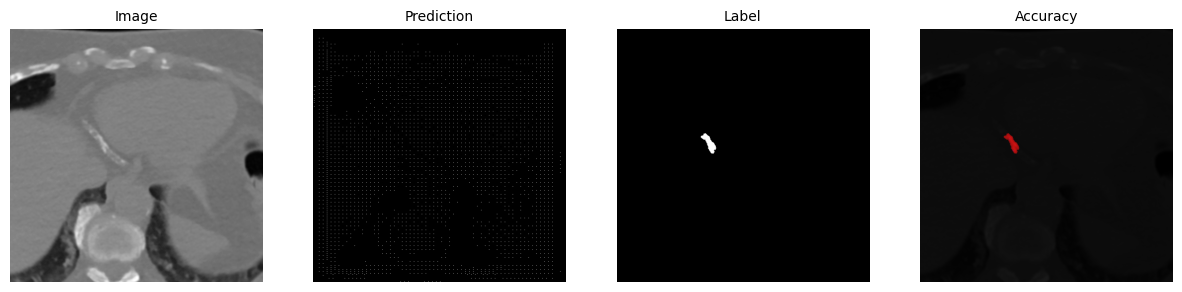

In [ ]:
run_inference(348, th=99)

# Save Model

Create folder 


Models\\model_name\\

For Each Training
Models\\baseline_0\\baseline_0.pt

In [ ]:
if CFG.train_new:
    os.mkdir(f"Models/{CFG.model_name}")
    os.mkdir(f"Models/{CFG.model_name}/logs")

AttributeError: type object 'CFG' has no attribute 'model_name'

In [ ]:
# Save History as JSON
log_num = len(os.listdir(f"Models/{CFG.model_name}/logs"))
with open(f"Models/{CFG.model_name}/logs/log_{log_num}", "w") as out_path:
    json.dump(history, out_path)

TypeError: Object of type Tensor is not JSON serializable

In [ ]:
torch.save(model, f"Models/baseline/{CFG.model_name}.pt")

In [ ]:
CFG.model_name

'baseline_1'

# Notes

* Dropout
* Pixel Level Accuracy
* Single Conv in Block (Save Memory)
* Check Zoom
* 3D UNET